# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [3]:
feature_names = []
#with open('../Data/mushroom.map') as fmap:
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

#with open('../Data/mushroom.data') as fdata:
with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

Components 	 Variance Explained
1 		 0.16
6 		 0.55
11 		 0.67
16 		 0.76
21 		 0.82
26 		 0.87
31 		 0.90
36 		 0.93
41 		 0.96
46 		 0.97


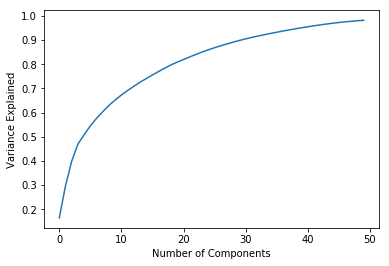

In [92]:
def P1():
### STUDENT START ###

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit(train_data)

    # Calculate the cumulative fraction of variance explained with
    # each additional component
    explained = np.cumsum(pca.explained_variance_ratio_)

    # show the results in a rough table
    print 'Components \t Variance Explained'

    for i, exp in enumerate(explained):
        if i % 5 == 0:
            print '{} \t\t {:.2f}'.format(i + 1, exp)

    # Plot the results
    plt.ylabel('Variance Explained')
    plt.xlabel('Number of Components')
    p = plt.plot(explained)

### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

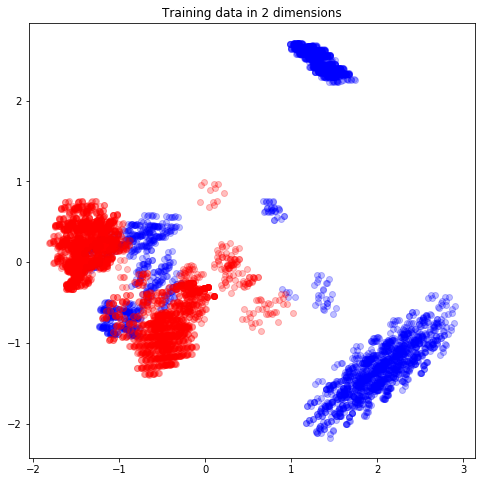

In [105]:
#def P2():
### STUDENT START ###

# reduce the 126 features to 2
reduced_data = PCA(n_components=2).fit_transform(train_data)

# separate the data into poisonous and non-poisonous cases
poison_indexes = np.where(train_labels == 1)
nonpoison_indexes = np.where(train_labels == 0)

poison = reduced_data[poison_indexes]
nonpoison = reduced_data[nonpoison_indexes]

# plot the cases with each feature corresponding to one axis
plt.figure(figsize=(8,8))
plt.title('Training data in 2 dimensions')
projected_data = plt.plot(poison[:, 0], poison[:, 1], 'bo', nonpoison[:, 0], nonpoison[:, 1], 'ro', alpha=.25)

### STUDENT END ###

#P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

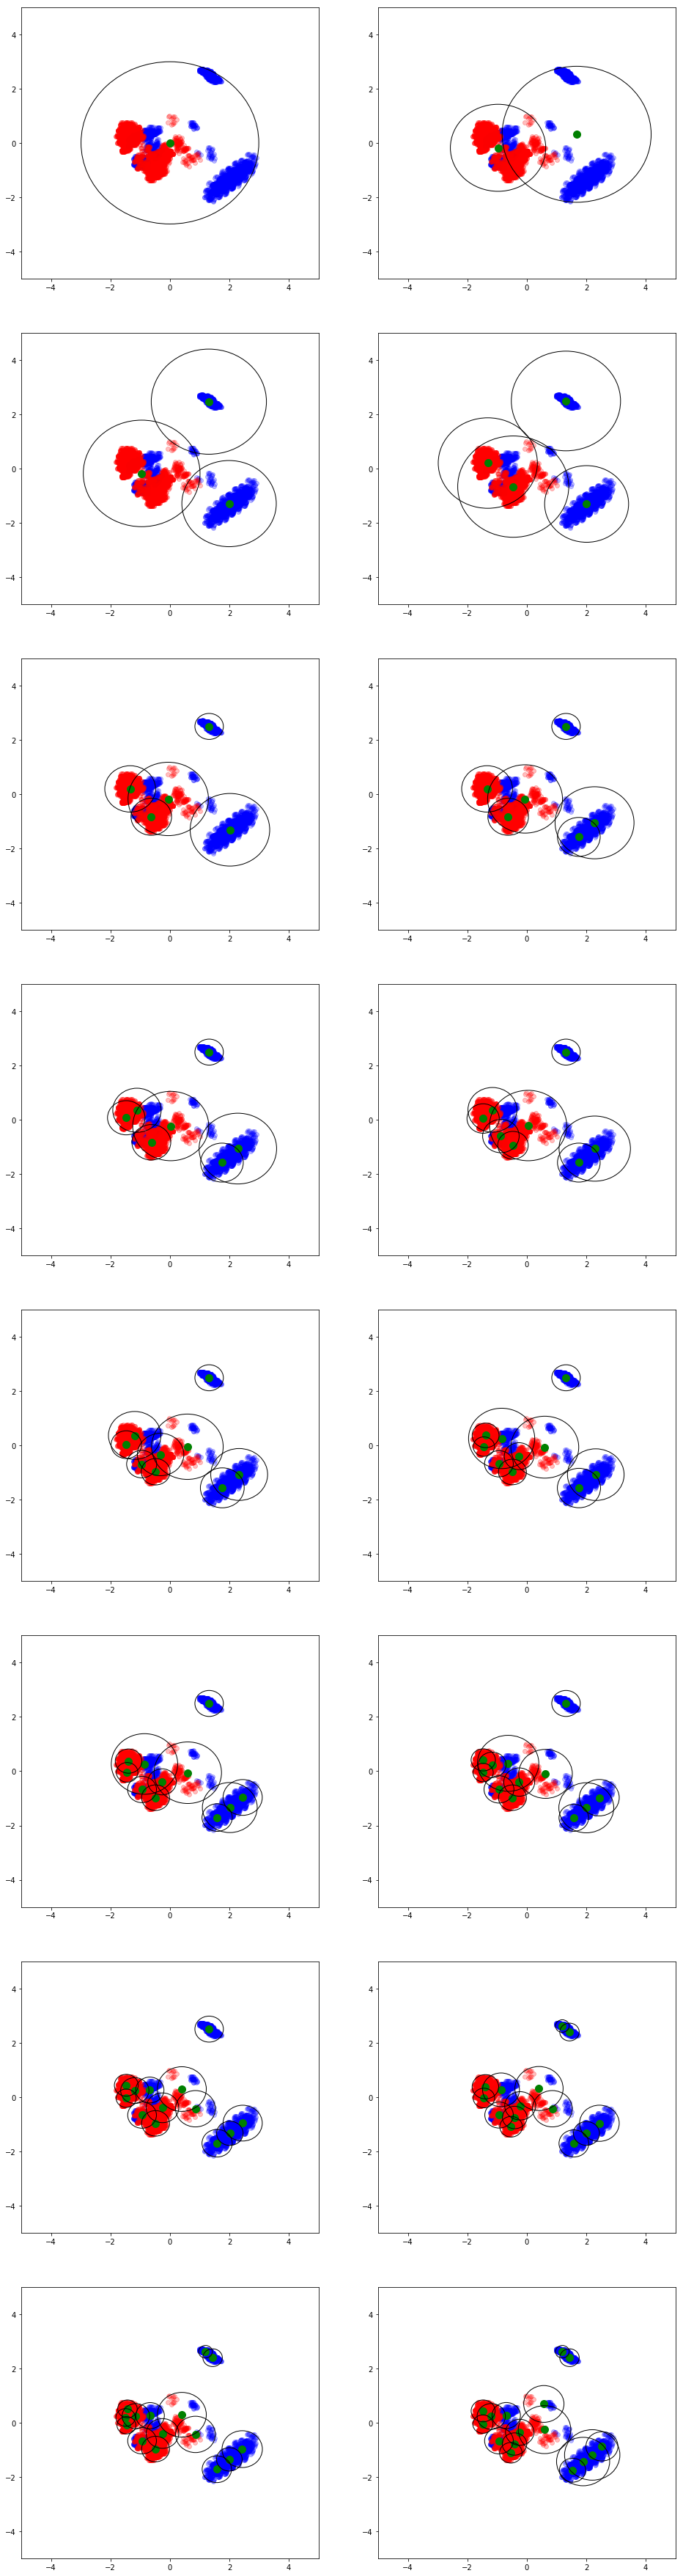

In [106]:
def P3():
### STUDENT START ###

    def k_means_cluster(num_clusters):
        this_ax = ax[num_clusters - 1]
        this_ax.set_xlim([-5, 5])
        this_ax.set_ylim([-5, 5])
        
        # get the clusters
        km = KMeans(n_clusters=num_clusters, init='k-means++')
        clusters = km.fit(reduced_data)

        # copy-pasta - plotting all the data
        this_ax.plot(poison[:, 0], poison[:, 1], 'bo', nonpoison[:, 0], nonpoison[:, 1], 'ro', alpha=0.25)

        # plotting
        for i, center in enumerate(clusters.cluster_centers_):
        
            # plot the center of this cluster
            this_ax.plot(center[0], center[1], 'go', markersize=10)

            # determine the farthest point from the center in this cluster
            points_in_cluster = np.where(clusters.labels_ == i)
            radius = metrics.pairwise_distances(center.reshape(1,2), reduced_data[points_in_cluster]).max()

            # plot a circle with a radius equal to that distance
            circle = plt.Circle(center, radius, fill=False, zorder=2)
            this_ax.add_artist(circle)

    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(16, 64))
    ax = ax.ravel()

    for i in range(1,17):
        k_means_cluster(i)
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

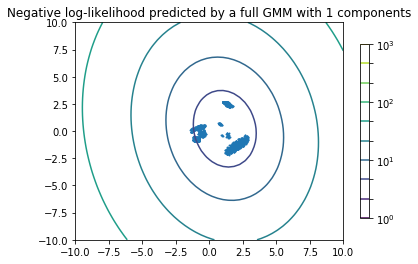

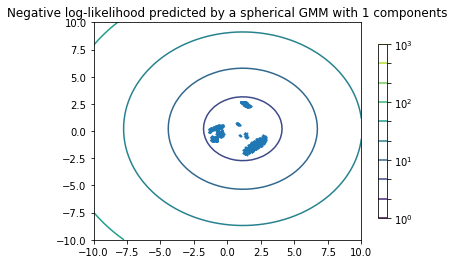

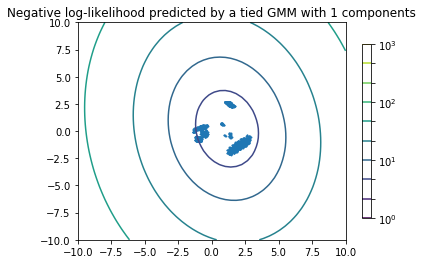

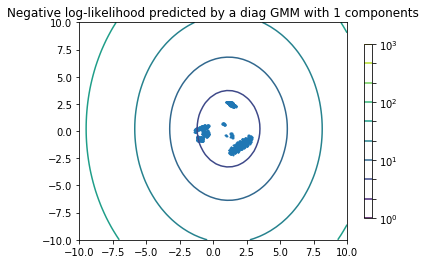

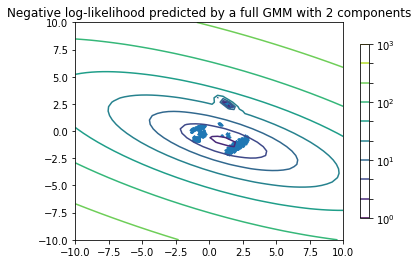

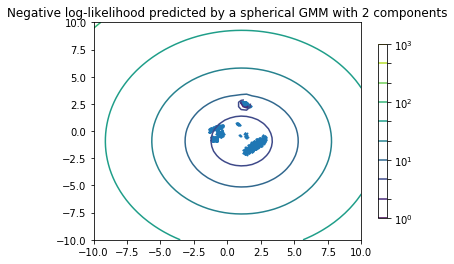

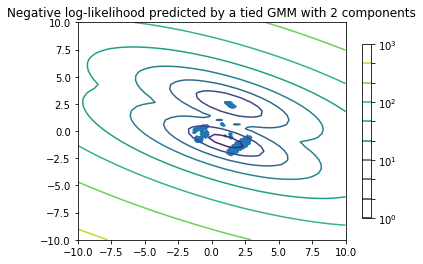

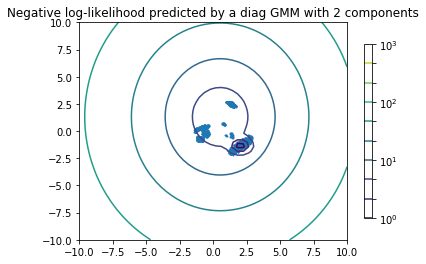

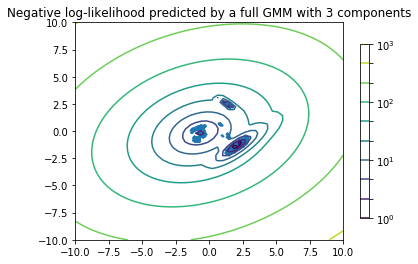

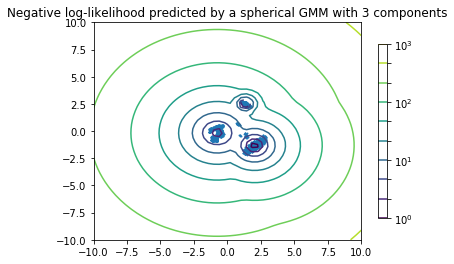

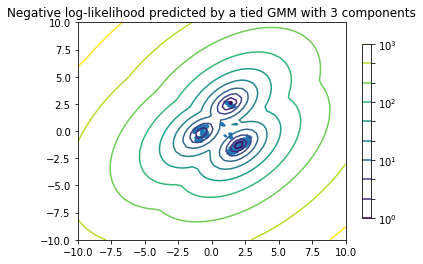

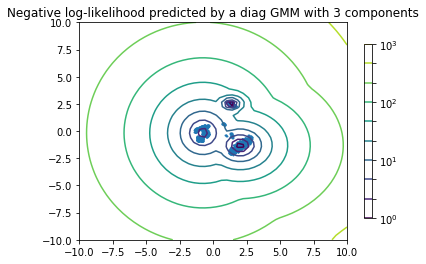

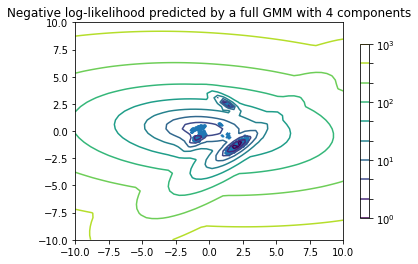

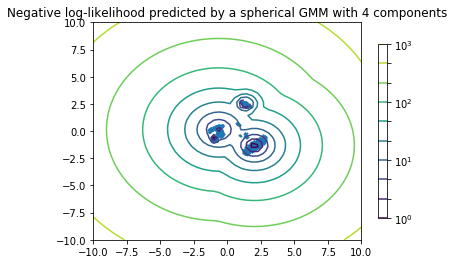

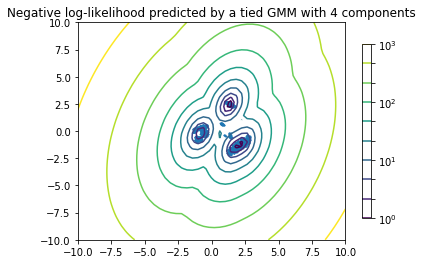

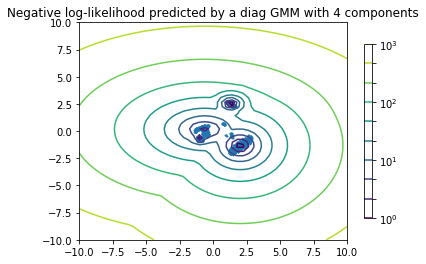

In [16]:
#def P4():
### STUDENT START ###
# GMM appears to be deprecated
from sklearn.mixture import GaussianMixture

def plot_density_contours(clf):
    ''' display predicted scores by the model as a contour plot '''
    x = np.linspace(-10., 10.)
    y = np.linspace(-10., 10.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(positive_examples[:, 0], positive_examples[:, 1], .8)

    title = 'Negative log-likelihood predicted by a {} GMM with {} components'.format(
        clf.covariance_type , clf.n_components)
    plt.title(title)
    plt.axis('tight')
    plt.show()

# we're concerned only with positive examples
positive_indexes = np.where(train_labels == 1)
positive_examples = reduced_data[positive_indexes]

# fit a Gaussian Mixture Model
for n in range(1, 5):
    for covar_type in ['full', 'spherical', 'tied', 'diag']:
        clf = GaussianMixture(n_components=n, covariance_type=covar_type)
        clf.fit(positive_examples)

        plot_density_contours(clf)
### STUDENT END ###

#P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [66]:
def P5():
### STUDENT START ###
    import warnings
    warnings.filterwarnings('ignore')

    # we need to reduce the test data as well? TODO: CONFIRM THIS
    pca = PCA(n_components=2).fit(train_data)
    reduced_test_data = pca.transform(test_data)

    # we have the positive examples from above
    # but need the negative examples as well
    negative_indexes = np.where(train_labels == 0)
    negative_examples = reduced_data[negative_indexes]

    # fit the two GMMs
    clf = GMM(n_components=4, covariance_type='full')
    clf.fit(positive_examples)
    pos_scores = clf.score(reduced_test_data)

    clf.fit(negative_examples)
    neg_scores = clf.score(reduced_test_data)

    # see which GMM gives a higher probability
    predicted = pos_scores > neg_scores

    # calculate the accuracy
    num_correct = len(np.where((predicted == test_labels) == True)[0])
    num_examples = len(test_labels)

    print 'The accuracy is {:.2f}%'.format(num_correct / float(num_examples) * 100)

### STUDENT END ###

P5()

The accuracy is 95.11%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [67]:
def P6():
### STUDENT START ###

    def get_number_of_parameters(num_pca_components, num_gmm_components, covariance_type):

        # from the docs
        component_type_to_num_components = {
            'spherical': 1,
            'tied': 2,
            'diag': 2,
            'full': 3
        }    

        NUM_CLASSES = 2

        return ((num_pca_components * 2) * num_gmm_components) * NUM_CLASSES


    def do_pca(num_components):
        
        pca = PCA(n_components = num_components).fit(train_data)

        return pca.transform(train_data), pca.transform(test_data)


    def score_model(num_pca_components, num_gmm_components, covariance_type):    
        
        # this is an invalid model
        if get_number_of_parameters(num_pca_components, num_gmm_components, covariance_type) > 50:
            return -1

        train_reduced, test_reduced = do_pca(num_pca_components)

        positive_examples = train_reduced[positive_indexes]
        negative_examples = train_reduced[negative_indexes]

        clf = GMM(n_components=num_gmm_components, covariance_type=covariance_type)
    
        clf.fit(positive_examples)
        pos_scores = clf.score(test_reduced)

        clf.fit(negative_examples)
        neg_scores = clf.score(test_reduced)

        # see which GMM gives a higher probability
        predicted = pos_scores > neg_scores

        # calculate the accuracy
        num_correct = len(np.where((predicted == test_labels) == True)[0])
        num_examples = len(test_labels)

        return num_correct / float(num_examples) * 100

    covariance_types = ['spherical', 'tied', 'diag', 'full']
    max_score = -1

    # try combinations of parameters to get the best accuracy

    for covar_type in covariance_types:
        for pca_components in range(1, 10):
            for gmm_components in range(1, 10):
                score = score_model(
                    num_pca_components=pca_components, 
                    num_gmm_components=gmm_components, 
                    covariance_type=covar_type)

                if score > max_score:
                    max_score = score
                    best_model = (pca_components, gmm_components, covar_type)

    print 'The model with the best accuracy has {} PCA components and a {}-component {} GMM.'.format(*best_model)
    print 'The accuracy is {:.2f}%, and the number of components is {}.'.format(
        max_score, get_number_of_parameters(*best_model))

### STUDENT END ###

P6()

The model with the best accuracy has 4 PCA components and a 3-component tied GMM.
The accuracy is 96.80%, and the number of components is 48.
